In [1]:
from google.colab import drive
drive.mount('/content/google_drive')



Mounted at /content/google_drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# file_path is the path where kaggle.json is present in the Google Drive


%cd /content
%pwd
%ls


/content
google_drive/  sample_data/


In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:35<00:00, 39.1MB/s]
100% 1.33G/1.33G [00:35<00:00, 40.4MB/s]


In [4]:
!unzip \*.zip  && rm *.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/im

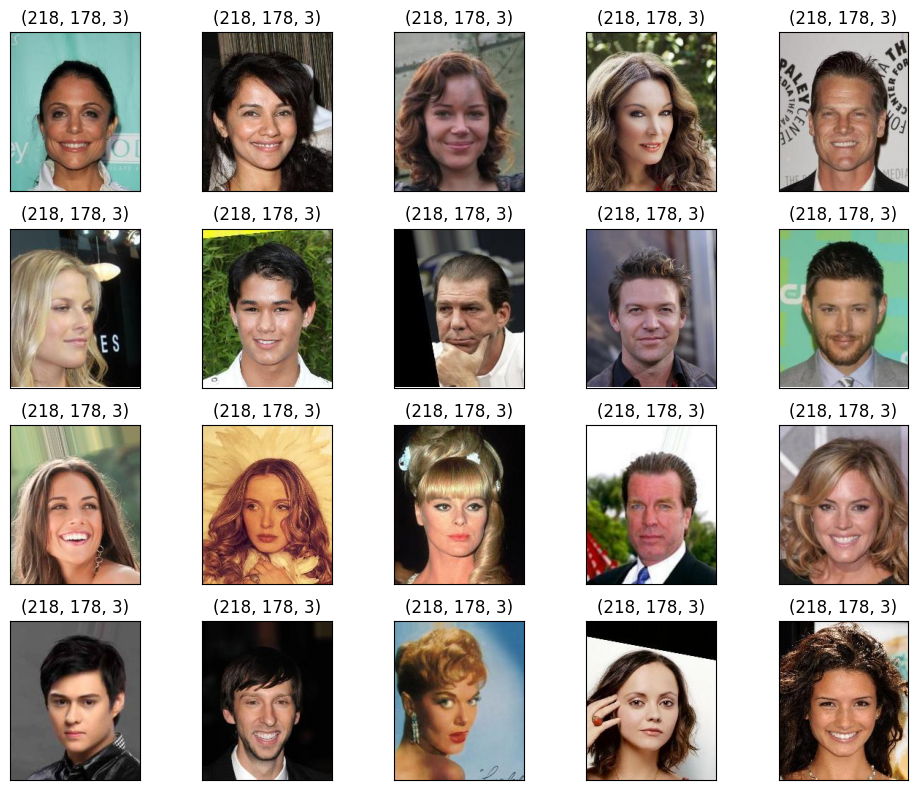

In [25]:

from glob import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import keras.backend as K
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
filenames = np.array(glob('img_align_celeba/img_align_celeba/*.jpg'))
plt.figure(figsize=(10, 8))
for i in range(20):
    img = plt.imread(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [63]:
X_train, X_test = train_test_split(filenames, test_size=1000)

In [66]:
def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
   # img = np.resize(img, size)
    return img

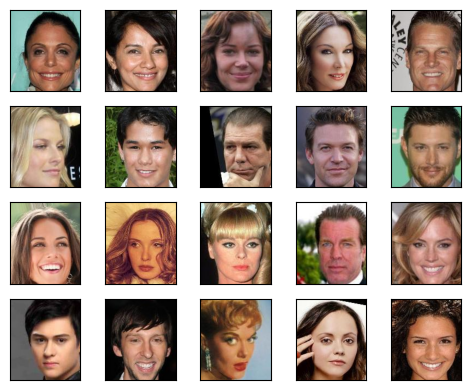

In [67]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = load_image(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

Object ` pip install torch` not found.


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision  # Убедитесь, что этот импорт присутствует
from sklearn.metrics import roc_auc_score
import time  # Импортируем модуль time для измерения времени

# Определение устройства (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# Параметры модели
batch_size = 128
latent_dim = 20  # Размер латентного пространства
epochs = 10
learning_rate = 1e-3

# Функция для фильтрации данных
def filter_digits(dataset, digits):
    indices = np.isin(dataset.targets, digits)
    return Subset(dataset, np.where(indices)[0])

# Загрузка набора данных MNIST
transform = transforms.ToTensor()

# Обучающая выборка: цифры 0-4
train_dataset_full = X_train
train_dataset = X_train

# Тестовая выборка: все цифры
test_dataset = X_test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определение архитектуры VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Энкодер
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)      # Среднее
        self.fc_logvar = nn.Linear(400, latent_dim)  # Логарифм дисперсии

        # Декодер
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Стандартное отклонение
        eps = torch.randn_like(std)  # Случайная нормальная шумовая переменная
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    # Kullback-Leibler дивергенция
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Инициализация модели и оптимизатора
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция обучения
def train(epoch):
    model.train()
    train_loss = 0
    epoch_start_time = time.time()  # Начало измерения времени эпохи
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Эпоха {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tПотеря: {loss.item() / len(data):.4f}")

    epoch_end_time = time.time()  # Конец измерения времени эпохи
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"====> Эпоха {epoch} Средняя потеря: {train_loss / len(train_loader.dataset):.4f} "
          f"Время: {epoch_duration:.2f} секунд")

# Функция тестирования
def test(epoch):
    model.eval()
    test_loss = 0
    test_start_time = time.time()  # Начало измерения времени тестирования
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()

    test_end_time = time.time()  # Конец измерения времени тестирования
    test_duration = test_end_time - test_start_time
    test_loss /= len(test_loader.dataset)
    print(f"====> Тестовая потеря: {test_loss:.4f} Время: {test_duration:.2f} секунд")

# Зафиксируем время начала всего скрипта
script_start_time = time.time()

# Обучение модели
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

# Генерация новых изображений
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()

    # Визуализация сгенерированных изображений
    grid_img = torchvision.utils.make_grid(sample.view(64, 1, 28, 28), nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title("Сгенерированные изображения VAE")
    plt.axis('off')
    plt.show()

# Восстановление изображений из тестового набора
def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        # Выбираем первые 8 изображений
        n = 8
        comparison = torch.cat([data[:n],
                                recon.view(batch_size, 1, 28, 28)[:n]])
        grid_img = torchvision.utils.make_grid(comparison, nrow=n)

        plt.figure(figsize=(16,4))
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title("Исходные изображения (верх) и Восстановленные VAE (низ)")
        plt.axis('off')
        plt.show()

visualize_reconstructions()

# Функция для вычисления ошибок восстановления
def compute_reconstruction_loss(loader):
    model.eval()
    losses = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            # Используем BCE без редукции для получения потерь на уровне каждого элемента
            loss = F.binary_cross_entropy(recon, data.view(-1, 28*28), reduction='none')
            # Суммируем потери по признакам для каждого образца
            loss = loss.sum(dim=1)
            losses.append(loss.cpu().numpy())
            labels.append(target.numpy())
    # Объединяем массивы потерь и меток
    losses = np.concatenate(losses)
    labels = np.concatenate(labels)
    return losses, labels

# Вычисление ошибок восстановления для обучающей и тестовой выборок
train_losses, _ = compute_reconstruction_loss(train_loader)
test_losses, test_labels = compute_reconstruction_loss(test_loader)

# Визуализация распределения ошибок восстановления
plt.figure(figsize=(10,6))
plt.hist(train_losses, bins=50, alpha=0.5, label='Обучающая выборка (нормальные данные)')
plt.hist(test_losses, bins=50, alpha=0.5, label='Тестовая выборка')
plt.legend(loc='upper right')
plt.title("Распределение ошибок восстановления")
plt.xlabel("Ошибка восстановления (BCE)")
plt.ylabel("Количество образцов")
plt.show()

# Установка порога для обнаружения аномалий
# Например, установим порог как 95-й процентиль ошибок восстановления обучающей выборки
threshold = np.percentile(train_losses, 95)
print(f"Порог для обнаружения аномалий (95-й процентиль): {threshold}")

# Обнаружение аномалий в тестовой выборке
anomaly_indices = np.where(test_losses > threshold)[0]
print(f"Количество аномалий в тестовой выборке: {len(anomaly_indices)}")

# Отображение некоторых аномалий
def show_anomalies(indices, labels, num=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num]):
        img = test_loader.dataset[idx][0].squeeze().numpy()
        label = labels[idx]
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Метка: {label}\nОшибка: {test_losses[idx]:.0f}")
        plt.axis('off')
    plt.show()

# Вывод первых 10 аномалий
show_anomalies(anomaly_indices, test_labels, num=10)

# Дополнительно: Метрики оценки
# Создание меток для аномалий
# Нормальные: 0 (цифры 0-4)
# Аномалии: 1 (цифры 5-9)
true_labels = (test_labels >=5).astype(int)
# Предсказанные баллы: ошибки восстановления
pred_scores = test_losses

# Вычисление AUC
auc = roc_auc_score(true_labels, pred_scores)
print(f"AUC для обнаружения аномалий: {auc:.4f}")

# Зафиксируем время окончания всего скрипта
script_end_time = time.time()
script_duration = script_end_time - script_start_time
print(f"Общее время выполнения скрипта: {script_duration:.2f} секунд")





# Функция для вычисления ошибок восстановления
def compute_reconstruction_loss(loader):
    model.eval()
    losses = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            # Используем BCE без редукции для получения потерь на уровне каждого элемента
            loss = F.binary_cross_entropy(recon, data.view(-1, 28*28), reduction='none')
            # Суммируем потери по признакам для каждого образца
            loss = loss.sum(dim=1)
            losses.append(loss.cpu().numpy())
            labels.append(target.numpy())
    # Объединяем массивы потерь и меток
    losses = np.concatenate(losses)
    labels = np.concatenate(labels)
    return losses, labels

# Вычисление ошибок восстановления для обучающей и тестовой выборок
train_losses, _ = compute_reconstruction_loss(train_loader)
test_losses, test_labels = compute_reconstruction_loss(test_loader)

# Визуализация распределения ошибок восстановления
plt.figure(figsize=(10,6))
plt.hist(train_losses, bins=50, alpha=0.5, label='Обучающая выборка (нормальные данные)')
plt.hist(test_losses, bins=50, alpha=0.5, label='Тестовая выборка')
plt.legend(loc='upper right')
plt.title("Распределение ошибок восстановления")
plt.xlabel("Ошибка восстановления (BCE)")
plt.ylabel("Количество образцов")
plt.show()

# Установка порога для обнаружения аномалий
# Например, установим порог как 95-й процентиль ошибок восстановления обучающей выборки
threshold = np.percentile(train_losses, 95)
print(f"Порог для обнаружения аномалий (95-й процентиль): {threshold}")

# Обнаружение аномалий в тестовой выборке
anomaly_indices = np.where(test_losses > threshold)[0]
print(f"Количество аномалий в тестовой выборке: {len(anomaly_indices)}")

# Отображение некоторых аномалий
def show_anomalies(indices, labels, num=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num]):
        img = test_loader.dataset[idx][0].squeeze().numpy()
        label = labels[idx]
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Метка: {label}\nОшибка: {test_losses[idx]:.0f}")
        plt.axis('off')
    plt.show()

# Вывод первых 10 аномалий
show_anomalies(anomaly_indices, test_labels, num=10)

# Дополнительно: Метрики оценки
# Создание меток для аномалий
# Нормальные: 0 (цифры 0-4)
# Аномалии: 1 (цифры 5-9)
true_labels = (test_labels >=5).astype(int)
# Предсказанные баллы: ошибки восстановления
pred_scores = test_losses

# Вычисление AUC
auc = roc_auc_score(true_labels, pred_scores)
print(f"AUC для обнаружения аномалий: {auc:.4f}")

# Зафиксируем время окончания всего скрипта
script_end_time = time.time()
script_duration = script_end_time - script_start_time
print(f"Общее время выполнения скрипта: {script_duration:.2f} секунд")


Используется устройство: cpu


ValueError: too many values to unpack (expected 2)